In [1]:
%matplotlib inline
import lux
#import pandas as pd
import modin.pandas as pd
from pyarrow import csv
import time
from lmfit import Model
from lmfit.models import *
from scipy.special import erfc
from scipy.interpolate import interp1d
import boost_histogram as bh
import matplotlib.pyplot as plt
from scipy import stats


from nicks_plot_utils import *

In [2]:
def read_csv(file_name: str = "", data: bool = False):
    names = [
        "electron_sector",
        "w",
        "q2",
        "theta",
        "phi",
        "mm2",
        "cut_fid",
        "helicty",
        "type"
    ]
    dtype = {
        "electron_sector": "int8",
        "helicty": "int8",
        "w": "float32",
        "q2": "float32",
        "theta": "float32",
        "phi": "float32",
        "mm2": "float32",
        "cut_fid": "bool",
    }


    # Load file into pyTable before changing to pandas
    pyTable = csv.read_csv(
        file_name,
        read_options=csv.ReadOptions(
            use_threads=True, column_names=names),
        convert_options=csv.ConvertOptions(column_types=dtype),
    )
    df = pyTable.to_pandas(strings_to_categorical=True)

    if data:
        return df.dropna()

    mc_rec = df[df.type == "mc_rec"].dropna()
    thrown = df[df.type == "thrown"].dropna()
    del df

    return (
        mc_rec,
        thrown,
    )

In [3]:
mc_data_file_path = "/Users/tylern/Data/e1d/data/mc_rec_e1d.csv"
rec_data_file_path = "/Users/tylern/Data/e1d/data/data_e1d.csv"

rec = read_csv(rec_data_file_path, True)

In [4]:
rec.head()

,electron_sector,w,q2,theta,phi,mm2,cut_fid,helicty,type
0,4,1.552897,1.199739,1.734403,0.576200,0.939656,True,-1,rec
1,5,1.421667,1.465422,0.233920,1.752785,0.926352,True,1,rec
2,1,1.438681,1.684511,0.507883,5.434877,0.897046,True,1,rec
3,1,1.466452,2.626151,0.400519,1.326395,0.864866,True,0,rec
4,1,1.776857,2.138597,1.745397,2.600946,1.354580,True,0,rec


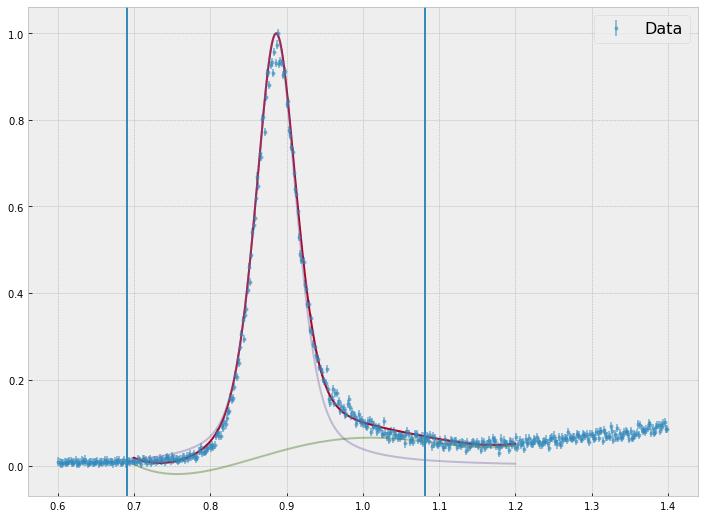

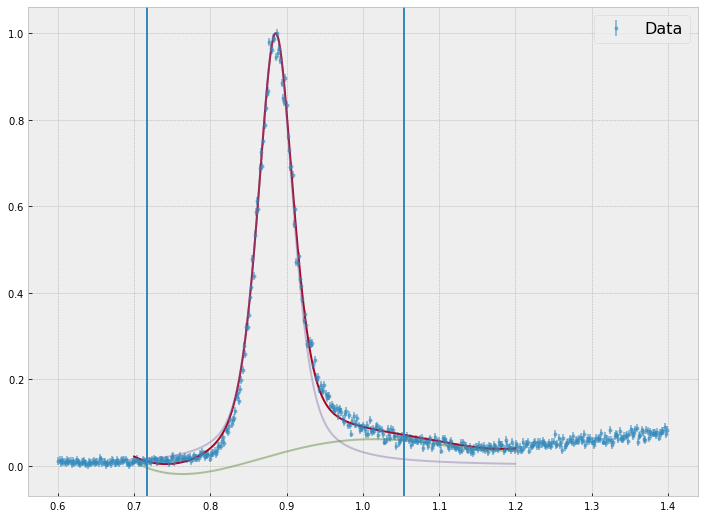

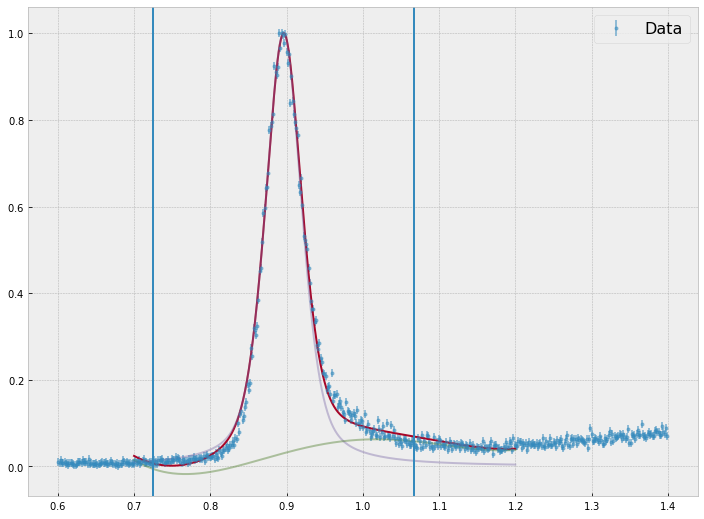

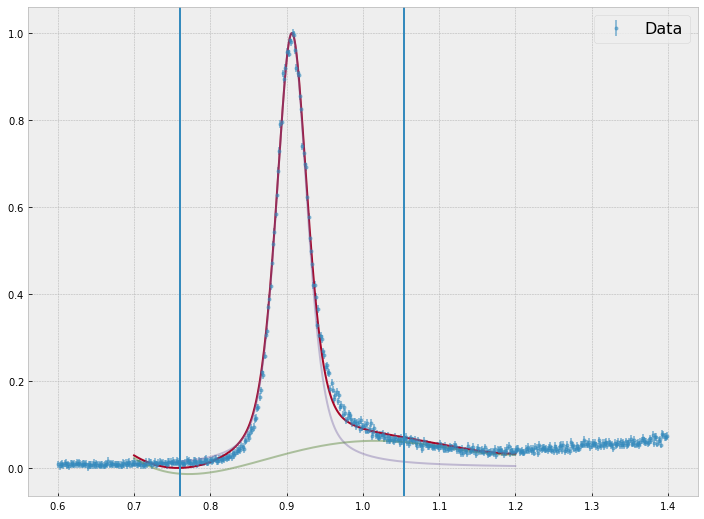

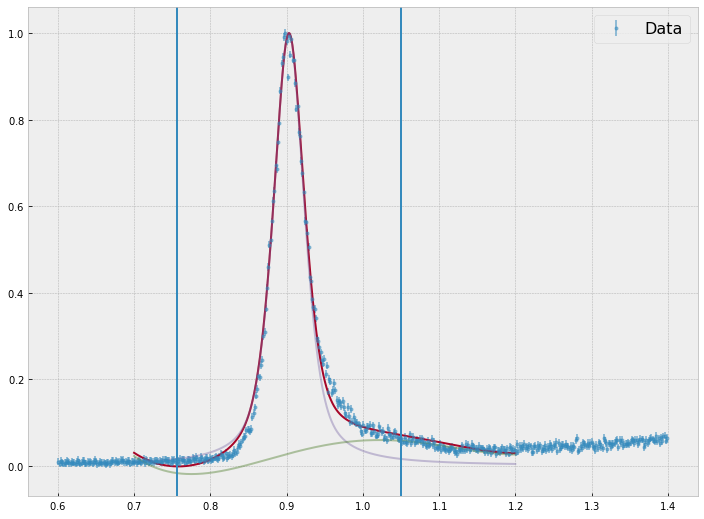

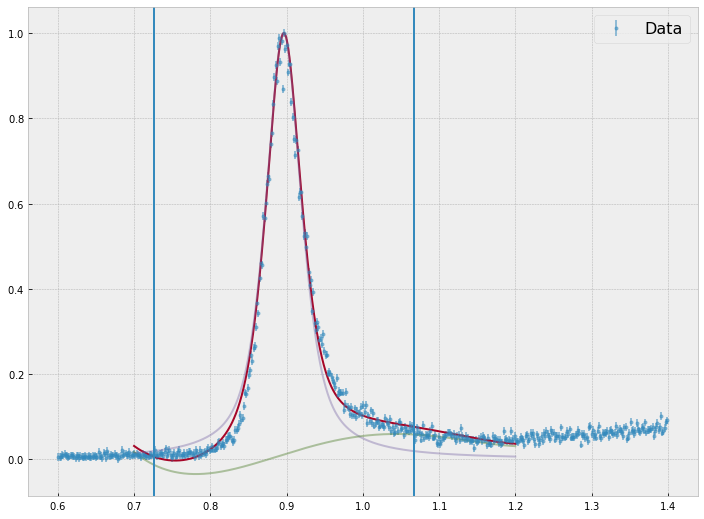

In [5]:
NSIGMA = 3
data = {}
for sec in range(1,7):
    fig, ax = plt.subplots(figsize=(12,9))
    mm2 = Hist1D(rec[rec.electron_sector == sec].mm2, bins=500, xrange=[0.6, 1.4])
    mm2.errorbar(ax, alpha=0.5, density=True, label='Data')

    x,y = mm2.hist_to_xy()

    peak = PseudoVoigtModel(prefix="peak_")
    # pars = peak.guess(y[(x > 0.8) & (x < 1.0)], x=x[(x > 0.8) & (x < 1.0)])
    pars = peak.guess(y, x=x)
    background = PolynomialModel(4,prefix="back_")
    pars.update(background.make_params())
    pars['peak_sigma'].set(value=0.028, min=0.0001, max=0.05)
    pars['back_c0'].set(value=-0.11)
    pars['back_c1'].set(value=0.18)
    pars['back_c2'].set(value=-0.039)
    pars['back_c3'].set(value=-0.000001, max=100, min=-100)
    pars['back_c4'].set(value=-0.000001, max=100, min=-100)
    # pars['back_c5'].set(value=-0.000001, max=100, min=-100)
    # pars['back_c6'].set(value=-0.000001, max=100, min=-100)
    # pars['back_c7'].set(value=-0.000001, max=100, min=-100)
    
    model = peak + background
    out = model.fit(y[(x > 0.7) & (x < 1.2)], pars, x=x[(x > 0.7) & (x < 1.2)], nan_policy='omit')
    
    xs= np.linspace(0.7,1.2,1000)
    plt.plot(xs, out.eval(params=out.params, x=xs)/np.max(out.eval(params=out.params, x=xs)))
#     dely = out.eval_uncertainty(x=xs, sigma=1)
#     dely = dely/np.max(dely)
#     yss = out.eval(params=out.params, x=xs)
#     yss = yss/np.max(yss)
#     plt.fill_between(xs, yss-dely, yss+dely, color='#888888')
    
#     peak = PseudoVoigtModel(prefix="peak_")
#     pars = peak.guess(y[(x > 0.8) & (x < 1.0)], x=x[(x > 0.8) & (x < 1.0)])
#     background = GaussianModel(prefix="back_")
#     pars.update(background.make_params())
#     model = peak + background
#     out = model.fit(y, pars, x=x)
    comps = out.eval_components(x=xs)      

    plt.plot(xs, comps['peak_']/np.max(comps['peak_']), alpha=0.4)
    plt.plot(xs, comps['back_']/np.max(comps['peak_']), alpha=0.4)

    plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_fwhm'])
    plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_fwhm']) 
#     data[sec] = (out.params['peak_center']-NSIGMA*out.params['peak_fwhm'], 
#                  out.params['peak_center']+NSIGMA*out.params['peak_fwhm'])
    

    plt.show()

    


In [11]:
# import numpy as np
# from iminuit import Minuit
# from probfit import UnbinnedLH, gaussian

# data = np.random.randn(10000)

# @np.vectorize
# def gaus(x, mean, sigma):
#     return gaussian(x, mean, sigma)


# unbinned_likelihood = UnbinnedLH(gaussian, rec[(rec.mm2 > 0.8) & (rec.mm2 < 1.1)].mm2.to_numpy())
# minuit = Minuit(unbinned_likelihood, mean=0.1, sigma=1.1)
# minuit.migrad()

# minuit.minos()

# xs = np.linspace(0.8, 1.1, 100)
# fig, ax = plt.subplots(figsize=(12,9))
# plt.plot(xs, gaus(xs, minuit.params['mean'].value, minuit.params['sigma'].value)/np.max(gaus(xs, minuit.params['mean'].value, minuit.params['sigma'].value)))
# mm2 = Hist1D(rec.mm2, bins=500, xrange=[0.6, 1.4])
# mm2.errorbar(ax, alpha=0.5, density=True, label='Data')

# plt.show()

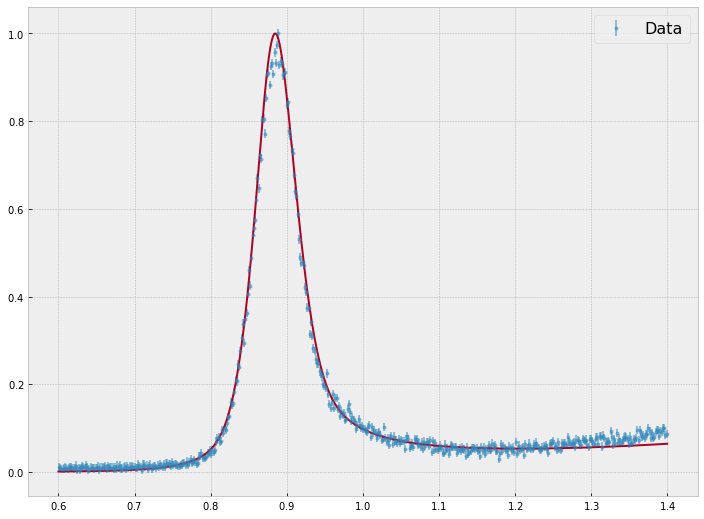

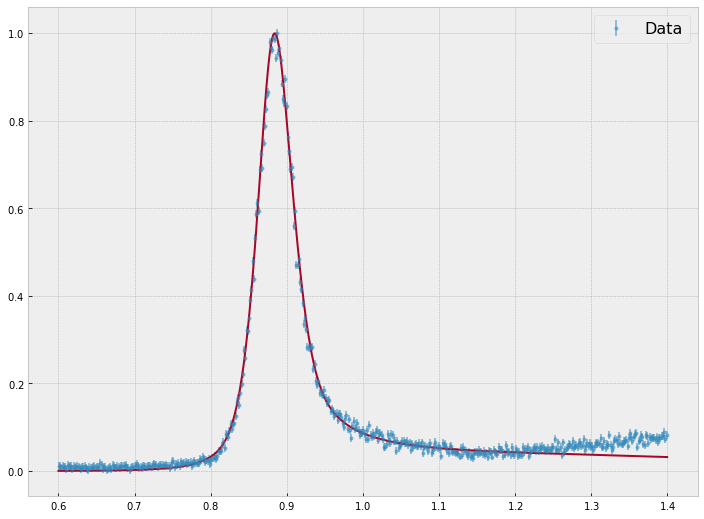

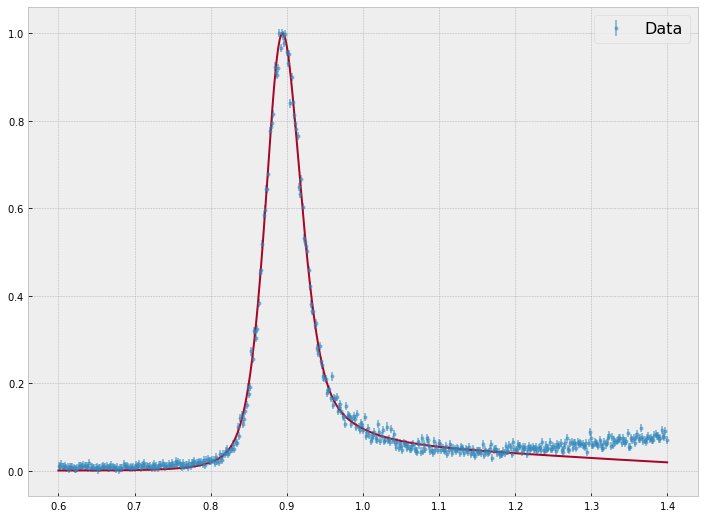

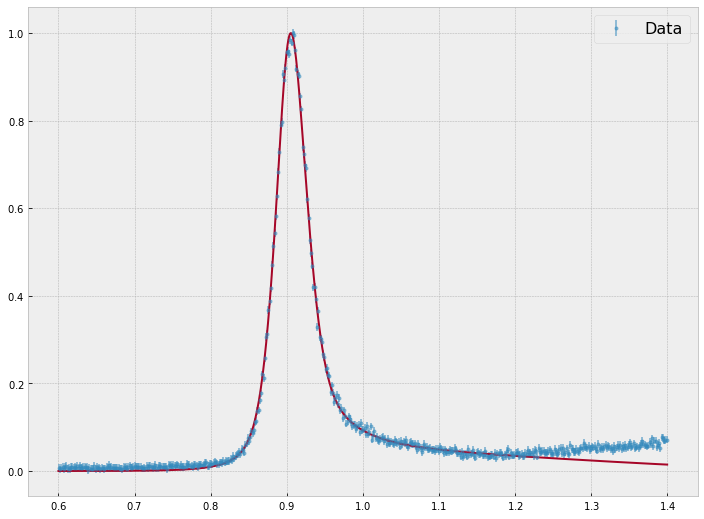

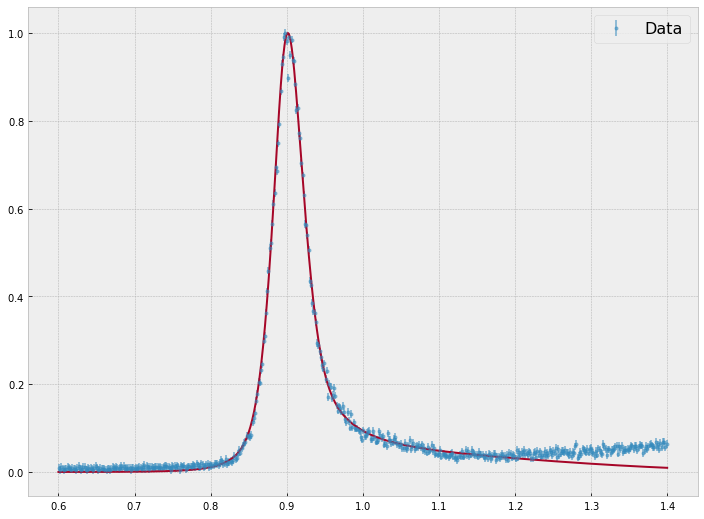

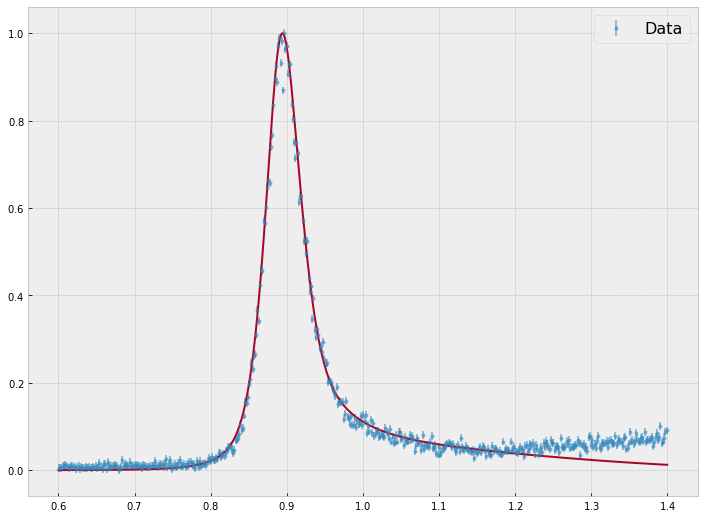

In [10]:
NSIGMA = 3
data = {}
for sec in range(1,7):
    fig, ax = plt.subplots(figsize=(12,9))
    mm2 = Hist1D(rec[rec.electron_sector == sec].mm2, bins=500, xrange=[0.6, 1.4])
    mm2.errorbar(ax, alpha=0.5, density=True, label='Data')

    x,y = mm2.hist_to_xy()

    peak = PseudoVoigtModel(prefix="peak_")
    # pars = peak.guess(y[(x > 0.8) & (x < 1.0)], x=x[(x > 0.8) & (x < 1.0)])
    pars = peak.guess(y, x=x)
    background = GaussianModel(prefix="back_")
    pars.update(background.make_params())
    
    model = peak * background
    out = model.fit(y[(x > 0.7) & (x < 1.2)], pars, x=x[(x > 0.7) & (x < 1.2)], nan_policy='omit')
    
    xs= np.linspace(0.6,1.4,1000)
    plt.plot(xs, out.eval(params=out.params, x=xs)/np.max(out.eval(params=out.params, x=xs)))
#     dely = out.eval_uncertainty(x=xs, sigma=1)
#     dely = dely/np.max(dely)
#     yss = out.eval(params=out.params, x=xs)
#     yss = yss/np.max(yss)
#     plt.fill_between(xs, yss-dely, yss+dely, color='#888888')
    
#     peak = PseudoVoigtModel(prefix="peak_")
#     pars = peak.guess(y[(x > 0.8) & (x < 1.0)], x=x[(x > 0.8) & (x < 1.0)])
#     background = GaussianModel(prefix="back_")
#     pars.update(background.make_params())
#     model = peak + background
#     out = model.fit(y, pars, x=x)
    #comps = out.eval_components(x=xs)      

    #plt.plot(xs, comps['peak_']/np.max(comps['peak_']), alpha=0.4)
    #plt.plot(xs, comps['back_']/np.max(comps['peak_']), alpha=0.4)

    #plt.axvline(out.params['peak_center']+NSIGMA*out.params['peak_fwhm'])
    #plt.axvline(out.params['peak_center']-NSIGMA*out.params['peak_fwhm']) 
#     data[sec] = (out.params['peak_center']-NSIGMA*out.params['peak_fwhm'], 
#                  out.params['peak_center']+NSIGMA*out.params['peak_fwhm'])
    

    plt.show()

    